# STAT 301 Final Group Project
##### Group 8 - Aayush Sharma, Shuyang Geng, Sungha Choi, William Cheng
------

In [20]:
# Import libraries
library(dplyr)
library(tidymodels)
library(infer)
library(cowplot)
library(GGally)
library(ggplot2)
library(grid)
library(gridExtra) 
library(tidyverse)
library(patchwork)
library(broom)

## Importing the Dataset

In [21]:
# Load data with correct columns
census_data <- read_csv("https://github.com/whalebeavercat/STAT-301-Census-Project/blob/main/data/adult.data?raw=TRUE", col_names = FALSE, show_col_types = FALSE)
col_names = c("age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "income")
colnames(census_data) <- col_names

head(census_data)
nrow(census_data)

age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


[1] 32561

`Table 1`: Initial Dataset

### Dataset Summary

The dataset being explored is the [1994 Census Income Data Set](https://archive.ics.uci.edu/dataset/2/adult) that explores personal annual income of US citizens in 1994. It is a reasonably clean dataset but it has some missing values in the coloumns *workclass*, *occupation*, and *native-country*. These missing values have been entered as "?" and will be removed from the dataset. The variables present in the dataset are:

- `age`: numeric variable, the age of a person in years. Only individuals with `age` > 16 were considered.
- `workclass`: categorical variable, type chr, represents the type of employement, such as Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
- `fnlwgt`: numeric variable, represent the final weight, meaning the number of people the census believes are represented by all the features in the row
- `education`: categorical variable, type chr, represents the highest education level obtained, such as Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
- `education-num`: numeric variable, the highest education level obtained in numeric form
- `marital-status`: categorical variable, type chr, represents the marital status for both civilian and Armed Forces marriages, such as Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
- `occupation`: categorical variable, type chr, represents the type of occupation the person has, such Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
- `relationship`: categorical variable, type chr, represents the relations the person has to others, similar to `maritial-status`, such as Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
- `race`: categorical variable, type chr, represents the race of the individual, such as White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
- `sex`: categorical variable, type chr, represents the biological sex, such as Female, Male.
- `capital-gain`: numeric variable, the capital gain for the individual or profit made by selling assets.
- `capital-loss`: numeric variable, the capital loss for the individual or loss from selling assets.
- `hours-per-week`: numeric variable, the number of hours per week the individual works.
- `native-country`: categorical variable, the country where the individual is born, such as United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.
- `income`: categorical variable, type logical, whether the individual makes <=50K or > 50K

### Question
The proposed question for this project is: Can we predict whether an individual earns >50K USD per year based on an individuals' `age`, `race`, education level (`education-num`), and `sex`. The aim of this project is to explore any significant bias in the income of an individual and thier personal background, which can be used to further explore a broader interest in understanding the complex interplay of numerous demographic factors in shaping individuals' income.



## Exploratory Data Analysis

### Cleaning and Wrangling the Dataset
Any row which contains the value "?" would be filtered out and the filtered dataset would then be processed again to remove all the unnecessary coloumns from the filtered dataset. This leaves us with a dataset with 30162 rows and 5 columns

In [22]:
census_data_clean <- census_data %>%
    filter_all(all_vars(. != "?")) %>%
    select(age, `education-num`, race, sex, income)
head(census_data_clean)
nrow(census_data_clean)

age,education-num,race,sex,income
<dbl>,<dbl>,<chr>,<chr>,<chr>
39,13,White,Male,<=50K
50,13,White,Male,<=50K
38,9,White,Male,<=50K
53,7,Black,Male,<=50K
28,13,Black,Female,<=50K
37,14,White,Female,<=50K


[1] 30162

`Table 2`: Wrangled and Cleaned Dataset

Given that the origninal dataset is a census dataset with large populations and various categories, it is more appropriate to take a sample from it. Taking a random sample can help identify trends, outliers, and potential issues without processing the entire dataset, improving computational efficiency. A simple random sample of size 1000 should be a good start as the sample is small enough to avoid introducing any biases. This sample dataset will then be s

In [47]:
sample_data <- census_data_clean %>%
    sample_n(size = 1000)
head(sample_data)

df_split <- initial_split(sample_data, prop = 0.8, strata = age)
df_train <- training(df_split)
df_test <- testing(df_split)

age,education-num,race,sex,income
<dbl>,<dbl>,<chr>,<chr>,<chr>
25,9,White,Male,<=50K
58,14,White,Male,>50K
44,14,White,Female,<=50K
34,10,White,Male,<=50K
29,9,Black,Male,<=50K
30,9,White,Male,<=50K


`Table 3`: Sampled Data

### Data Visualization

Using histograms and bar graphs, we compare the distribution of each factor.

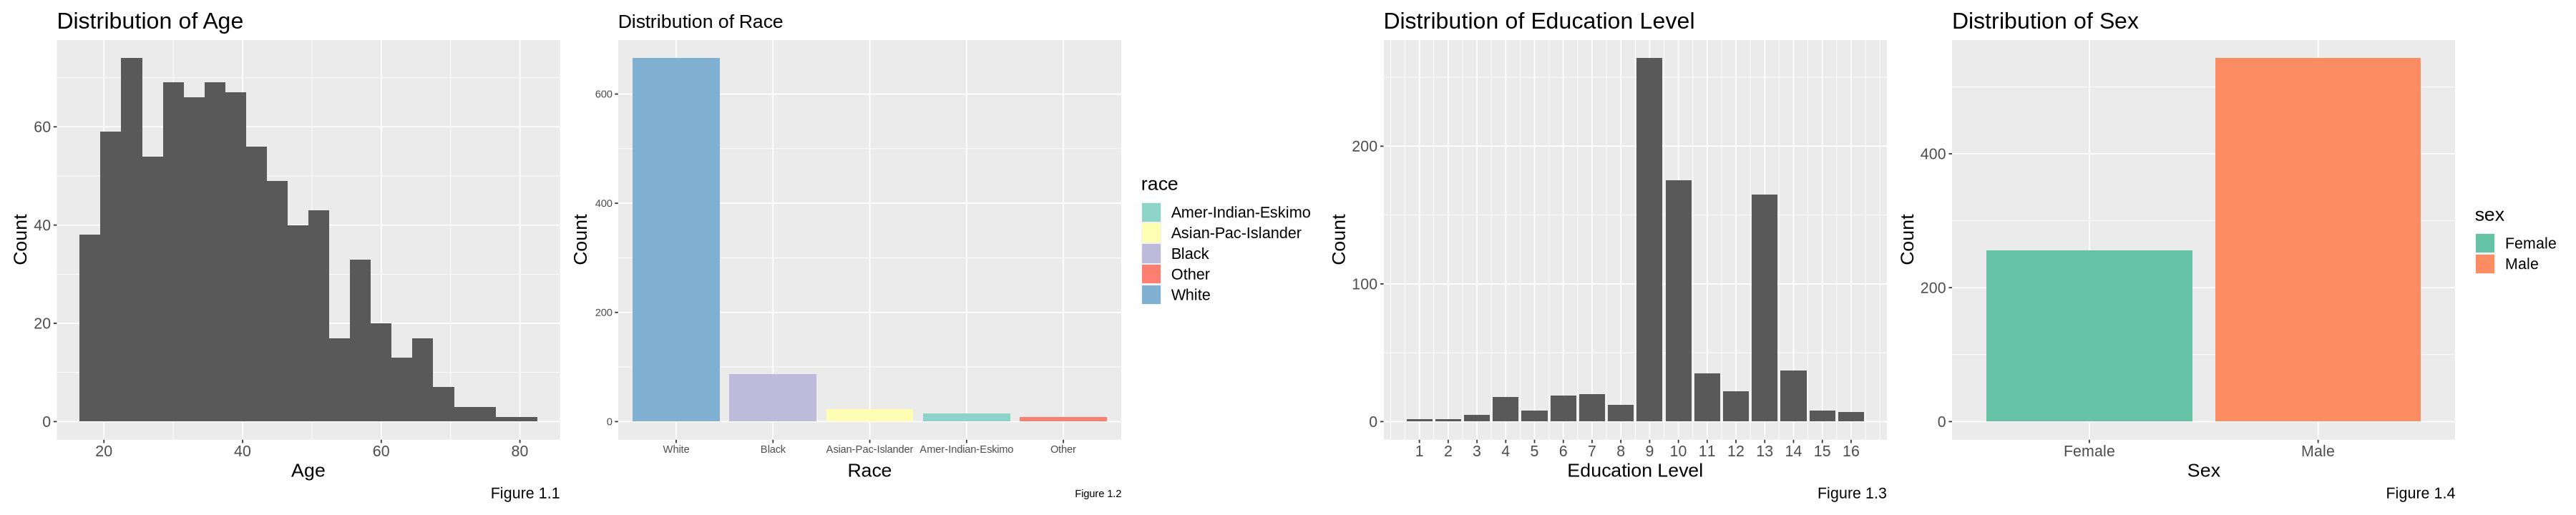

In [28]:
options(repr.plot.width = 30, repr.plot.height = 6)

# Histogram for age
bar_age <- ggplot(df_train, aes(x = age)) + 
    geom_histogram(binwidth = 3) +
    labs(title = "Distribution of Age", 
         x = "Age",
         y = "Count",
        caption = "Figure 1.1") +
    theme(text = element_text(size = 16))


# Count the number and proportion of individuals in race to help order the bars in descending order
table_race <- count(df_train, race) |>
mutate(prop = round(n / nrow(df_train), 3))

# Bar graph for race
bar_race <- ggplot(table_race, aes(x = reorder(race, -n), y = n, fill = race)) + 
    geom_bar(stat = "identity") +
    labs(title = "Distribution of Race", 
         x = "Race", 
         y = "Count",
        caption = "Figure 1.2")+ 
    scale_fill_brewer(palette = "Set3") +
    theme(plot.title = element_text(size = 16),
          axis.title.x = element_text(size = 16),
          axis.title.y = element_text(size = 16),
          legend.title = element_text(size = 16),
          legend.text = element_text(size = 13))



# Bar graph for education level
bar_education <- ggplot(df_train, aes(x = `education-num`)) + 
    geom_bar() +
    labs(title = "Distribution of Education Level", 
         x = "Education Level",
         y = "Count",
         caption = "Figure 1.3") +
    scale_x_continuous(breaks = seq(1, 16, by = 1)) +
    theme(text = element_text(size = 16))
                       

# Bar graph for sex
bar_sex <- ggplot(df_train, aes(x = sex, fill = sex)) + 
    geom_bar() +
    labs(title = "Distribution of Sex",
         x = "Sex",
         y = "Count",
        caption = "Figure 1.4") + 
    scale_fill_brewer(palette = "Set2") +
    theme(text = element_text(size = 16))


(bar_age | bar_race | bar_education | bar_sex) + plot_layout(ncol = 4)

The plots above provide insights into the overall trends of each factor. Figure 1.1 shows that the mean age is around 38 years. The distribution is slightly right-skewed, indicating that a larger number of individuals are younger than the mean age. The dataset predominantly consists of individuals of White racial background, and individuals with education levels of 9, 10, and 11. Additionally, there are approximately twice as many males as there are females in the dataset.

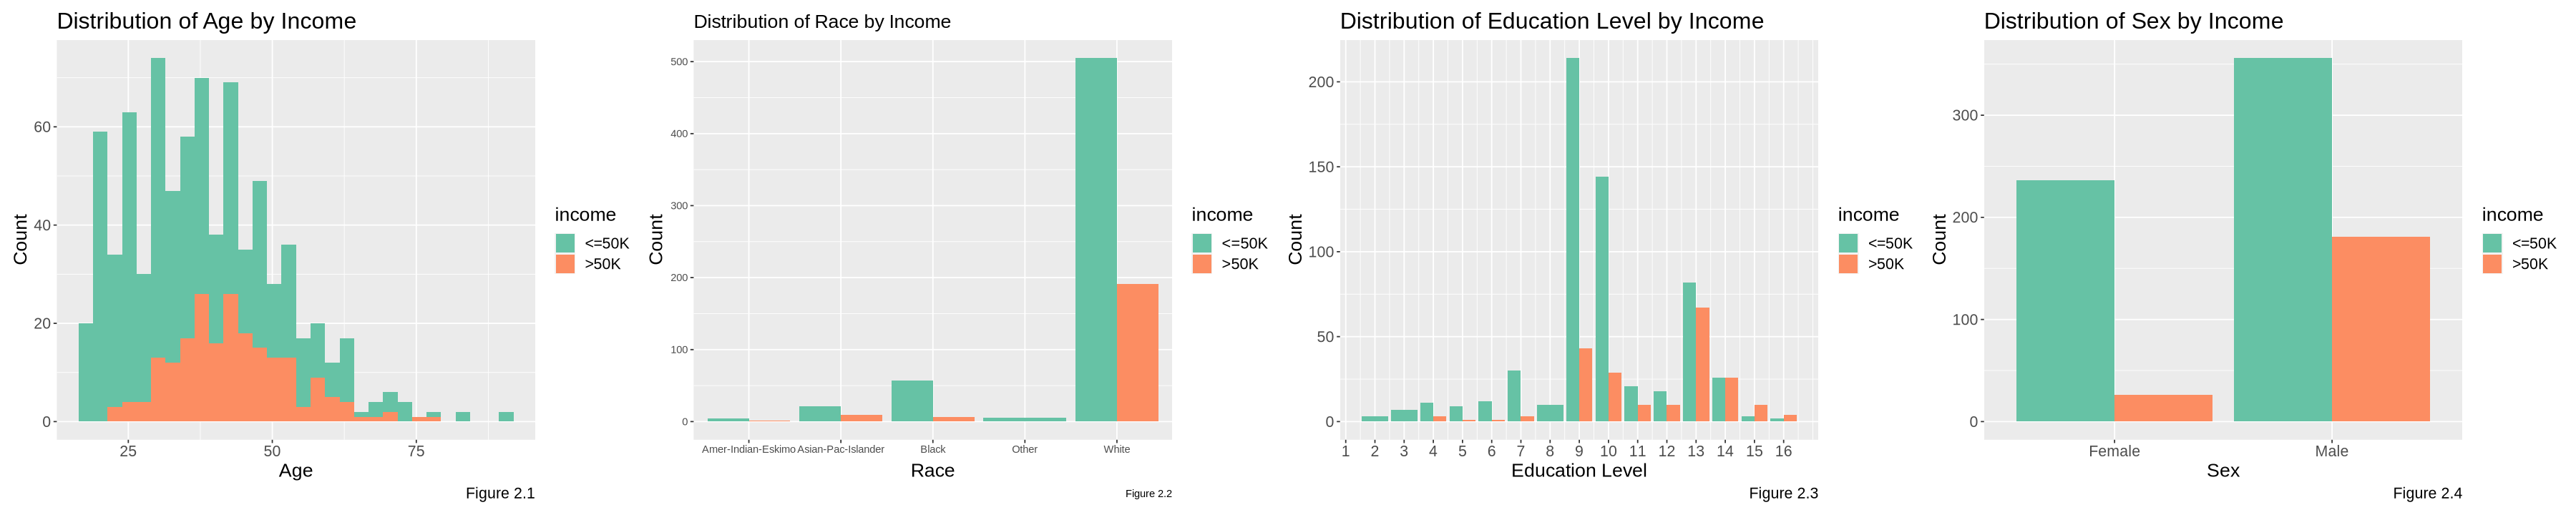

In [36]:
options(repr.plot.width = 30, repr.plot.height = 6)


# Histogram for age by income
plot_age_income <- ggplot(df_train, aes(x = age, fill = income)) + 
    geom_histogram(bins = 30) +
    labs(title = "Distribution of Age by Income", 
         x = "Age",
         y = "Count",
         caption = "Figure 2.1") + 
    scale_fill_brewer(palette = "Set2") + 
    theme(text = element_text(size = 16))


# Bar plot for race by income
plot_race_income <- ggplot(df_train, aes(x = race, fill = income)) + 
    geom_bar(position = "dodge") +
    labs(title = "Distribution of Race by Income",
        x = "Race",
        y = "Count",
        caption = "Figure 2.2") + 
    scale_fill_brewer(palette = "Set2") +
    theme(plot.title = element_text(size = 16),
          axis.title.x = element_text(size = 16),
          axis.title.y = element_text(size = 16),
          legend.title = element_text(size = 16),
          legend.text = element_text(size = 13))


# Bar plot for education level by income
plot_education_income <- ggplot(df_train, aes(x = `education-num`, fill = income)) + 
    geom_bar(position = "dodge") +
    labs(title = "Distribution of Education Level by Income", 
         x = "Education Level",
         y = "Count",
         caption = "Figure 2.3") + 
    scale_fill_brewer(palette = "Set2") + 
    scale_x_continuous(breaks = seq(1, 16, by = 1)) +
    theme(text = element_text(size = 16))


# Bar plot for sex by income
plot_sex_income <- ggplot(df_train, aes(x = sex, fill = income)) + 
    geom_bar(position = "dodge") +
    labs(title = "Distribution of Sex by Income",
        x = "Sex",
        y = "Count",
        caption = "Figure 2.4") + 
    scale_fill_brewer(palette = "Set2") +
    theme(text = element_text(size = 16))


(plot_age_income | plot_race_income | plot_education_income | plot_sex_income) + plot_layout(ncol = 4)

Here, we compare the distribution of each factor by `income` using histograms and grouped bar charts. Figure 2.1 demonstrates that individuals earning over \\$50K generally exhibit a more normally distributed age profile, with a higher mean age of around 43, compared to approximately 36 for those earning less than or equal to \\$50K. Figure 2.2 indicates that a higher proportion of White individuals earn above \\$50K compared to other races. Figure 2.3 reveals that no individuals in education level 1 earn above \\$50K, while those with education levels 14, 15, and 16 are more likely to surpass this income threshold. Lastly, Figure 2.4 shows that a greater proportion of males earn above \\$50K compared to females.

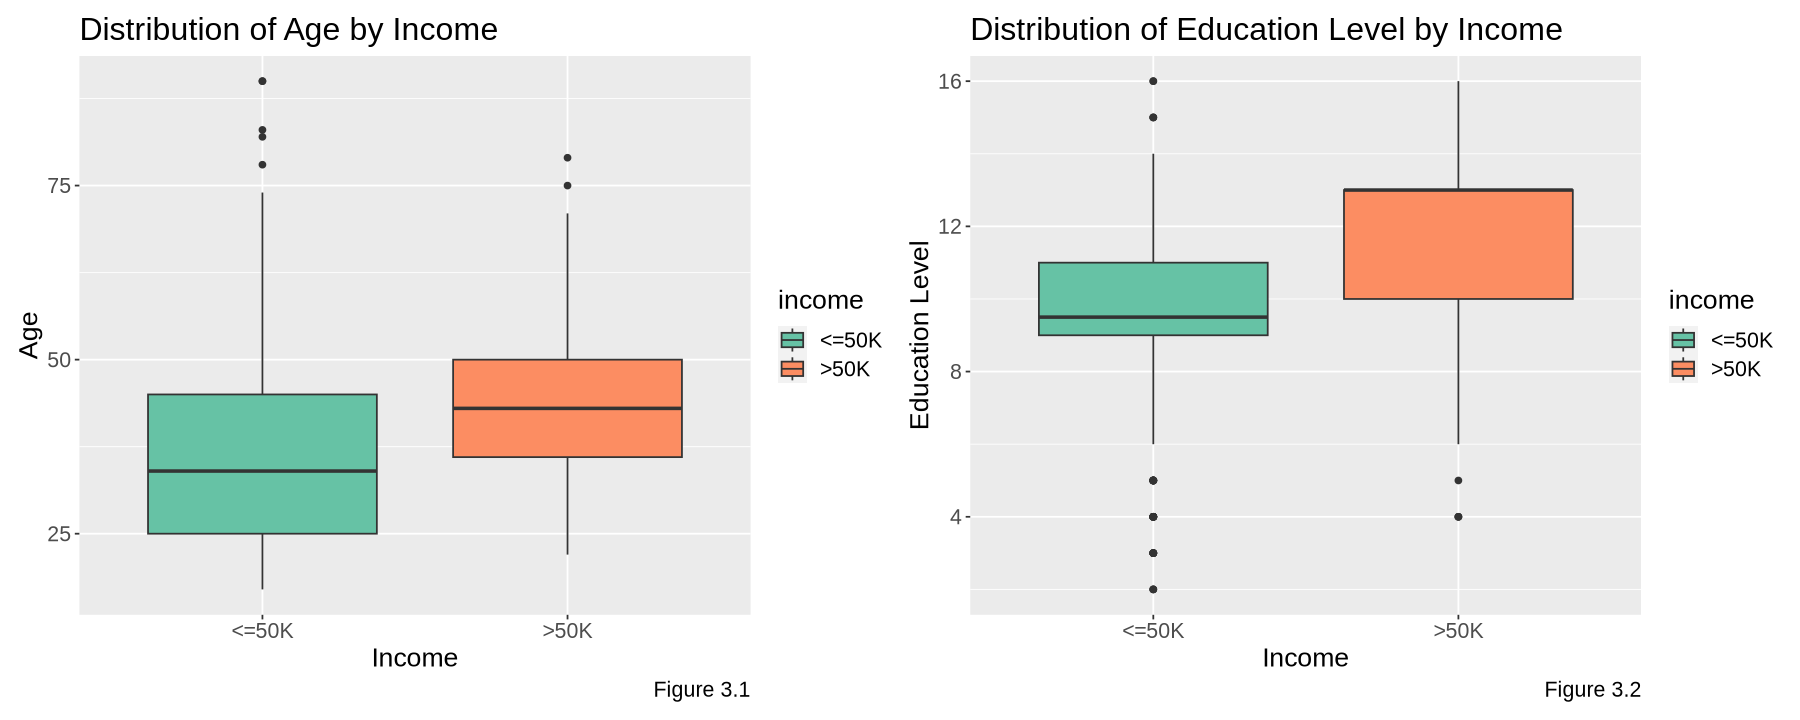

In [46]:
options(repr.plot.width = 15, repr.plot.height = 6)

# side by side box plot to compare the distribution of age by income
box_age_income <- ggplot(df_train, aes(x = income, y = age, fill = income)) + 
    geom_boxplot() +
    labs(title = "Distribution of Age by Income", 
         x = "Income", 
         y = "Age",
         caption = "Figure 3.1") + 
    scale_fill_brewer(palette = "Set2") +
    theme(text = element_text(size = 16))

# side by side box plot to compare the distribution of education level by income
box_education_income <- ggplot(df_train, aes(x = income, y = `education-num`, fill = income)) + 
    geom_boxplot() +
    labs(title = "Distribution of Education Level by Income", 
         x = "Income", 
         y = "Education Level",
         caption = "Figure 3.2") + 
    scale_fill_brewer(palette = "Set2") +
    theme(text = element_text(size = 16))


(box_age_income | box_education_income) + plot_layout(ncol = 2)

Figure 3.1 presents that those earning more than \\$50K generally display a higher median age, with their boxplot positioned slightly above that of individuals earning \\$50K or less. However, the considerable overlap between the distributions suggests that the age difference is not substantially significant.

With Figure 3.2, it becomes more apparent that individuals with higher education levels tend to have higher incomes (>50K). This is evident from the fact that, for incomes <=50K, the lower quartile and median education levels are 9, and the upper quartile is 10. Conversely, for incomes >50K, the lower quartile is 10, the median is 12, and the upper quartile is 13.


This series of histograms, bar plots, and boxplots visually illustrates the distribution of individuals across income brackets within various demographic categories (age, race, education level, sex). By analyzing the patterns in these plots, we can gain insights into how income is distributed across different demographic groups and identify potential correlations between demographic factors and income.